In [1]:
import numpy as np
import pandas as pd
import toad
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from toad.plot import bin_plot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score

In [2]:
parse_dates = ['CreatedDate', 'RequestedDate', 'AccTime', 'PupTime', 'DelTime']
data = pd.read_csv('Booking_Dispatch_training_set.csv', parse_dates = parse_dates, \
                   date_parser = lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H:%M:%S"))

In [3]:
parse_dates2 = ['CreatedDate', 'RequestedDate']

validation = pd.read_csv('Booking_Dispatch_validation_set.csv', parse_dates = parse_dates2, \
                   date_parser = lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H:%M:%S"))

In [4]:
data.shape
# (3000000, 37)

(3000000, 37)

In [5]:
validation.shape

(300000, 17)

In [6]:
data['TargetVariable'].value_counts()/len(data)

Completed    0.776306
Cancelled    0.128554
No Job       0.082690
ELSE         0.012449
Name: TargetVariable, dtype: float64

In [7]:
# binary target: 'Cancelled'
target_dict = {'Cancelled':1,'Completed':0,'ELSE':0,'No Job':0,}
data['target_2cls_Cancelled'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_Cancelled'] = validation['TargetVariable'].replace(target_dict)

# binary target: 'Completed'
target_dict = {'Cancelled':0,'Completed':1,'ELSE':0,'No Job':0,}
data['target_2cls_Completed'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_Completed'] = validation['TargetVariable'].replace(target_dict)

# binary target: 'ELSE'
target_dict = {'Cancelled':0,'Completed':0,'ELSE':1,'No Job':0,}
data['target_2cls_ELSE'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_ELSE'] = validation['TargetVariable'].replace(target_dict)

# binary target: 'No Job'
target_dict = {'Cancelled':0,'Completed':0,'ELSE':0,'No Job':1,}
data['target_2cls_NoJob'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_NoJob'] = validation['TargetVariable'].replace(target_dict)

In [8]:
# 4分类target
target_dict2 = {
    'Cancelled':0,
    'Completed':1,
    'No Job':2,
    'ELSE':3,
}

data['target_4cls'] = data['TargetVariable'].replace(target_dict2)
validation['target_4cls'] = validation['TargetVariable'].replace(target_dict2)

In [9]:
validation.columns

Index(['BookingID', 'BookingSource', 'Conditions', 'HasCondition',
       'IsAccountBooking', 'CreatedDate', 'RequestedDate', 'BookingFleet',
       'DispatchFleet', 'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb',
       'PuLat', 'PuLong', 'FinalDispatchStatus', 'TargetVariable',
       'target_2cls_Cancelled', 'target_2cls_Completed', 'target_2cls_ELSE',
       'target_2cls_NoJob', 'target_4cls'],
      dtype='object')

In [10]:
# 可以入模的 features + target ; 即排除
cols = ['BookingID', 'BookingSource', 'Conditions', 'HasCondition', 'IsAccountBooking', 'CreatedDate', 'RequestedDate', 'BookingFleet'
        , 'DispatchFleet', 'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb', 'PuLat', 'PuLong', 'TargetVariable','target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob','target_4cls']
data = data[cols]
validation=validation[cols]

# 2. Feature Engineering

## 2.1 Suburb

<AxesSubplot:xlabel='PuSuburb', ylabel='prop'>

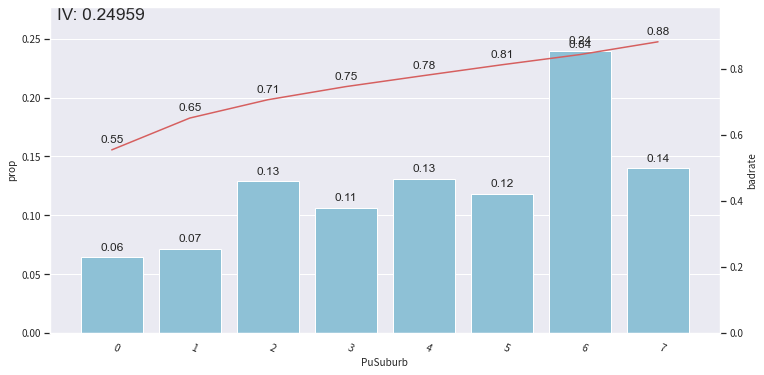

In [11]:
c = toad.transform.Combiner()
col = 'PuSuburb'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05) # DT, Kmeans, Quantile, Step 
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')

<AxesSubplot:xlabel='PuSuburb', ylabel='prop'>

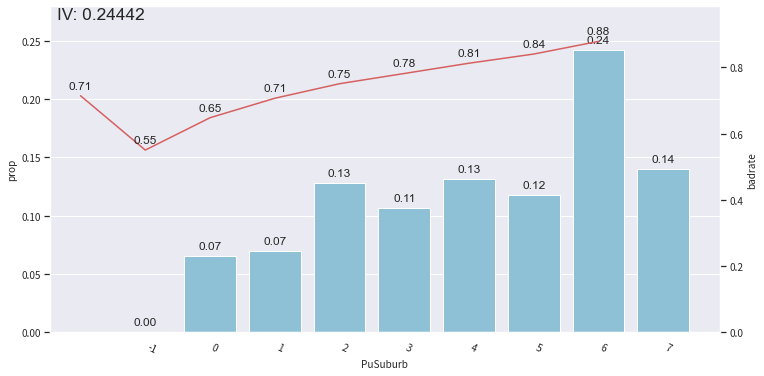

In [12]:
# 在validation上测试
bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed') 

# 由于-1的关系，有一个位移，忽视掉
#结论：train的IV0.2495，test时0.2444，稳定性非常好且iv很高；分箱的梯度非常明显

In [13]:
c.export()

{'PuSuburb': [['Bathurst',
   'Lithgow',
   'Brownlow Hill',
   'South Maroota',
   'Pitt Town',
   'Clarendon',
   'Lansdowne',
   'Windsor',
   'Hobartville',
   'Wollongong',
   'Bowenfels',
   'Glenmore',
   'South Windsor',
   'Audley',
   'Douglas Park',
   'Warrimoo',
   'Balmoral (South)',
   'Gosford',
   'Scotland Island',
   'Ku-Ring-Gai Chase',
   'Ebenezer',
   'Londonderry',
   'Cottage Point',
   'Wilton',
   'Oakdale',
   'Berkshire Park',
   'Cattai',
   'Palm Beach',
   'Whale Beach',
   'Springwood',
   'Oakville',
   'Mulgrave',
   'Mcgraths Hill',
   'Shanes Park',
   'The Oaks',
   'Port Kembla',
   'REGENTS PARK',
   'Sun Valley',
   'Werombi',
   'Lakesland',
   'Kelso',
   'Hill Top (North)',
   'HAYMARKET',
   'Belimbla Park',
   'Kurmond',
   'Vineyard',
   'Bligh Park',
   'Mount Vernon',
   'Agnes Banks',
   'Winmalee',
   'Windsor Downs',
   'Castlereagh',
   'Shalvey',
   'Bringelly',
   'WEST HOXTON',
   'Bilgola Beach',
   'Thirroul',
   'Wallerawang',


In [14]:
def PuSuburbBins(data,data_test):
    data = data.copy()
    data_test = data_test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'PuSuburb'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.05) 
        data['PuSuburbBins_'+val] = c.transform(data[['PuSuburb']], labels=False) # 纯分箱不做woe转化
        data_test['PuSuburbBins_'+val] = c.transform(data_test[['PuSuburb']], labels=False)
    return data, data_test

data, validation = PuSuburbBins(data, validation)


In [15]:
data[['PuSuburbBins_Cancelled','PuSuburbBins_Completed','PuSuburbBins_ELSE','PuSuburbBins_NoJob']].head()

,PuSuburbBins_Cancelled,PuSuburbBins_Completed,PuSuburbBins_ELSE,PuSuburbBins_NoJob
0,0,6,0,3
1,4,3,1,3
2,2,5,0,2
3,2,5,0,3
4,6,0,1,6


In [16]:
toad.quality(data[['PuSuburbBins_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')

,iv,gini,entropy,unique
PuSuburbBins_Cancelled,0.249979,0.217016,0.369365,7.0


In [17]:
toad.quality(data[['PuSuburbBins_Completed','target_2cls_Completed']],target='target_2cls_Completed')

,iv,gini,entropy,unique
PuSuburbBins_Completed,0.249585,0.331691,0.509915,8.0


In [18]:
toad.quality(data[['PuSuburbBins_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')

,iv,gini,entropy,unique
PuSuburbBins_ELSE,0.216695,0.02451,0.065578,2.0


In [19]:
toad.quality(data[['PuSuburbBins_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')

,iv,gini,entropy,unique
PuSuburbBins_NoJob,0.227563,0.149151,0.276917,8.0


In [20]:
#每个target的IV都很高，因此每个衍生变量都有效

## 2.2 Pickup lattitude & longitude

In [21]:
knn = KNeighborsClassifier(n_neighbors = 101)

knn.fit(data[['PuLat','PuLong']],data['target_2cls_Completed'])

data['KNN_temp'] = knn.predict_proba(data[['PuLat','PuLong']])[:,1]

<AxesSubplot:xlabel='KNN_temp', ylabel='prop'>

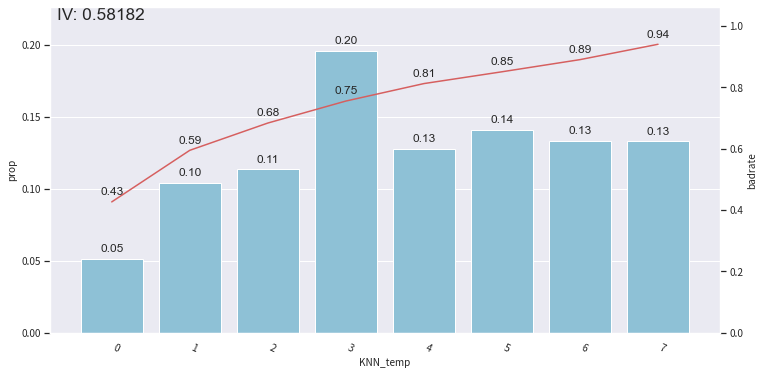

In [22]:
c = toad.transform.Combiner()
col = 'KNN_temp'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


<AxesSubplot:xlabel='KNN_temp', ylabel='prop'>

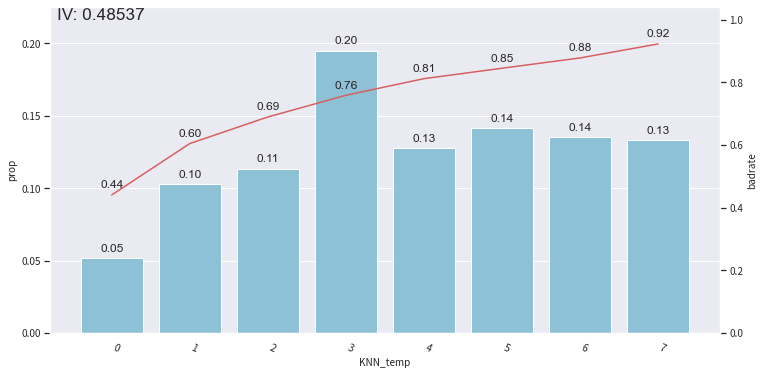

In [23]:
validation['KNN_temp'] = knn.predict_proba(validation[['PuLat','PuLong']])[:,1]
bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


In [24]:
c.export()

{'KNN_temp': [0.5346534653465347,
  0.6534653465346535,
  0.7227722772277227,
  0.801980198019802,
  0.8415841584158416,
  0.8811881188118812,
  0.9207920792079208]}

In [25]:
def PuLatLongKNN(data, test):
    data = data.copy()
    test = test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        knn = KNeighborsClassifier(n_neighbors = 101)
        knn.fit(data[['PuLat','PuLong']],data[target])
        data['PuLatLongKNN_'+val] = knn.predict_proba(data[['PuLat','PuLong']])[:,1]
        test['PuLatLongKNN_'+val] = knn.predict_proba(test[['PuLat','PuLong']])[:,1]
    return data, test 

data,validation = PuLatLongKNN(data,validation)

In [26]:
toad.quality(data[['PuLatLongKNN_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')

# 计算剩下的IV，可以给出bin_plot证明分箱的梯度明显

,iv,gini,entropy,unique
PuLatLongKNN_Cancelled,0.709143,0.212199,0.383407,91.0


## 2.3 Time

In [27]:
def OrderHour(data):
    data = data.copy()
    data['OrderHour'] = data['RequestedDate'].apply(lambda x: x.hour).astype(int)
    return data 
data = OrderHour(data)
validation= OrderHour(validation)

<AxesSubplot:xlabel='OrderHour', ylabel='prop'>

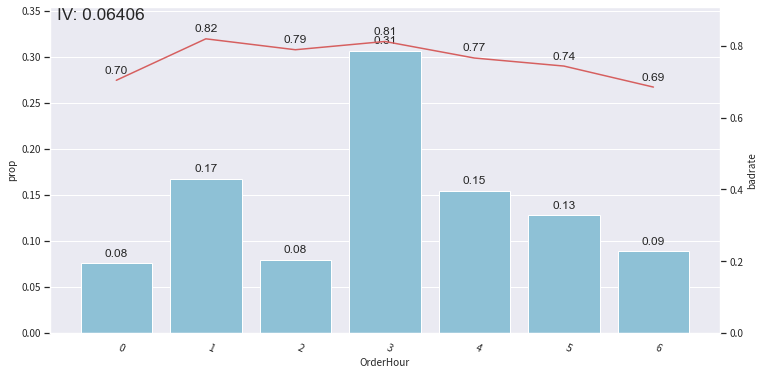

In [28]:
c = toad.transform.Combiner()
col = 'OrderHour'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


In [29]:
def DayOfWeek(data):
    data = data.copy()
    data['DayOfWeek'] = data['RequestedDate'].apply(lambda x: x.weekday()+1)
    return data
data = DayOfWeek(data)
validation = DayOfWeek(validation)

<AxesSubplot:xlabel='DayOfWeek', ylabel='prop'>

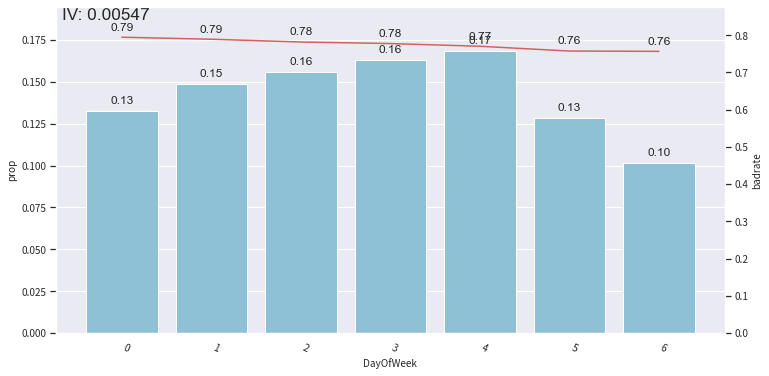

In [30]:
c = toad.transform.Combiner()
col = 'DayOfWeek'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


In [31]:
dt = DecisionTreeClassifier(max_depth = 4,min_samples_leaf=0.05)
dt.fit(data[['DayOfWeek','OrderHour']] , data['target_2cls_Completed'])

def OrderTimeDT(data):
    data = data.copy()
    data['OrderTimeDT'] = dt.predict_proba(data[['DayOfWeek','OrderHour']])[:,1]
    return data 

In [32]:
data = OrderTimeDT(data)
validation = OrderTimeDT(validation)

<AxesSubplot:xlabel='OrderTimeDT', ylabel='prop'>

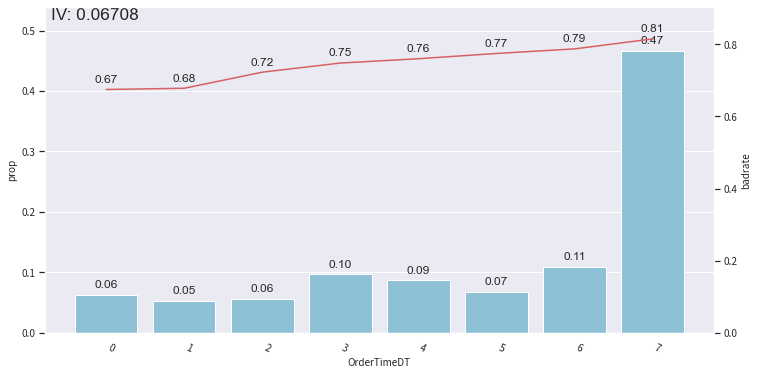

In [33]:
c = toad.transform.Combiner()
col = 'OrderTimeDT'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')


In [34]:
def OrderTimeDT(data, test):
    data = data.copy()
    test = test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        dt = DecisionTreeClassifier(max_depth = 4,min_samples_leaf=0.05)
        dt.fit(data[['DayOfWeek','OrderHour']] , data[target])
        data['OrderTimeDT_'+val] = dt.predict_proba(data[['DayOfWeek','OrderHour']])[:,1]
        test['OrderTimeDT_'+val] = dt.predict_proba(test[['DayOfWeek','OrderHour']])[:,1]
    return data, test 

data,validation = OrderTimeDT(data,validation)

In [35]:
toad.quality(data[['OrderTimeDT_Completed','target_2cls_Completed']],target='target_2cls_Completed')

,iv,gini,entropy,unique
OrderTimeDT_Completed,0.067079,0.343049,0.52564,8.0


In [37]:
train_features = data[['BookingSource','Conditions',
     'HasCondition','IsAccountBooking','CreatedDate','RequestedDate',
     'BookingFleet','DispatchFleet','AreaNumber','PuPlace','PuAddress',
     'PuSuburb','PuLat','PuLong','TargetVariable']]

In [38]:
# Changing the pickup_datetime and dropoff_datetime from object to datetime datatype
data['CreatedDate']=pd.to_datetime(data['CreatedDate'])
data['RequestedDate']=pd.to_datetime(data['RequestedDate'])

In [39]:
# Creating features based on day
data['create_by_day'] = data['CreatedDate'].dt.day_name()
data['request_by_day'] = data['RequestedDate'].dt.day_name()

In [40]:
# Creating features based on Hour
data['create_by_hour'] = data['CreatedDate'].dt.hour
data['request_by_hour'] = data['RequestedDate'].dt.hour
#Morning, which starts at 6:01 am and ends at 12:oopm
#Afternoon, which starts at 12:01 pm and ends at 18:00pm
#Evening, which starts at 18:01 and ends at 21:00pm
#Night, which start at 21:01 and ends at 6:00am

In [41]:
def part_of_day (t):
    if t in range (6,12):
        return "Morning"
    elif t in range (12,18):
        return "Afternoon"
    elif t in range (18,21):
        return "Evening"
    else:
        return "Night"

In [42]:
data['create_part_of_day']=data['create_by_hour'].apply(part_of_day)
data['request_part_of_day']=data['request_by_hour'].apply(part_of_day)

In [43]:
validation['CreatedDate']=pd.to_datetime(validation['CreatedDate'])
validation['RequestedDate']=pd.to_datetime(validation['RequestedDate'])
validation['create_by_day'] = validation['CreatedDate'].dt.day_name()
validation['request_by_day'] = validation['RequestedDate'].dt.day_name()
validation['create_by_hour'] = validation['CreatedDate'].dt.hour
validation['request_by_hour'] = validation['RequestedDate'].dt.hour
validation['create_part_of_day']=validation['create_by_hour'].apply(part_of_day)
validation['request_part_of_day']=validation['request_by_hour'].apply(part_of_day)

## 2.4 Conditions

<AxesSubplot:xlabel='Conditions', ylabel='prop'>

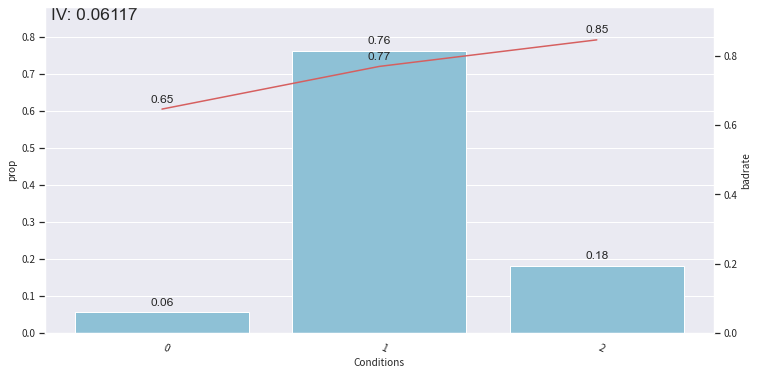

In [44]:
data['Conditions'] = data['Conditions'].astype(str) # condition 属于 cateogorical fearture, 本身是numerical所以会被认为是continous feature
validation['Conditions'] = validation['Conditions'].astype(str)
c = toad.transform.Combiner()
col = 'Conditions'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')

In [45]:
def ConditionsBins(data, test):
    data = data.copy()
    test = test.copy()
    data['Conditions'] = data['Conditions'].astype(str)
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'Conditions'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.05)
        data['ConditionsBins_'+val] = c.transform(data[['Conditions']], labels=False)
        test['ConditionsBins_'+val] = c.transform(test[['Conditions']], labels=False)
    return data, test

data, validation = ConditionsBins(data, validation)

## 2.5 Booking Fleet = Dispatch Fleet

In [46]:
equal = list()
for i in range(data.shape[0]):
    if data['BookingFleet'][i] == data['DispatchFleet'][i]:
        equal.append('True')
    else:
        equal.append('False')

In [47]:
equal2 = list()
for i in range(validation.shape[0]):
    if validation['BookingFleet'][i] == validation['DispatchFleet'][i]:
        equal2.append('True')
    else:
        equal2.append('False')

In [48]:
data['BookingisDispatch'] = equal
validation['BookingisDispatch'] = equal2

In [49]:
data.columns

Index(['BookingID', 'BookingSource', 'Conditions', 'HasCondition',
       'IsAccountBooking', 'CreatedDate', 'RequestedDate', 'BookingFleet',
       'DispatchFleet', 'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb',
       'PuLat', 'PuLong', 'TargetVariable', 'target_2cls_Cancelled',
       'target_2cls_Completed', 'target_2cls_ELSE', 'target_2cls_NoJob',
       'target_4cls', 'PuSuburbBins_Cancelled', 'PuSuburbBins_Completed',
       'PuSuburbBins_ELSE', 'PuSuburbBins_NoJob', 'KNN_temp',
       'PuLatLongKNN_Cancelled', 'PuLatLongKNN_Completed', 'PuLatLongKNN_ELSE',
       'PuLatLongKNN_NoJob', 'OrderHour', 'DayOfWeek', 'OrderTimeDT',
       'OrderTimeDT_Cancelled', 'OrderTimeDT_Completed', 'OrderTimeDT_ELSE',
       'OrderTimeDT_NoJob', 'create_by_day', 'request_by_day',
       'create_by_hour', 'request_by_hour', 'create_part_of_day',
       'request_part_of_day', 'ConditionsBins_Cancelled',
       'ConditionsBins_Completed', 'ConditionsBins_ELSE',
       'ConditionsBins_NoJob', 'Bo

In [50]:
data = data.drop(columns=['BookingID', 'Conditions','CreatedDate', 'RequestedDate',
                         'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb','PuLat', 
                          'PuLong', 'TargetVariable','KNN_temp','OrderHour', 'DayOfWeek',
                         'create_by_day','request_by_day', 'create_by_hour', 'request_by_hour',
                          'create_part_of_day', 'request_part_of_day','OrderTimeDT'])

In [51]:
validation=validation.drop(columns=['BookingID', 'Conditions','CreatedDate', 'RequestedDate',
                         'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb','PuLat', 
                          'PuLong', 'TargetVariable','KNN_temp','OrderHour', 'DayOfWeek',
                         'create_by_day','request_by_day', 'create_by_hour', 'request_by_hour',
                          'create_part_of_day', 'request_part_of_day','OrderTimeDT'])

In [52]:
data=pd.get_dummies(data)

In [53]:
data = data.drop(columns=['HasCondition_No','IsAccountBooking_No','HasCondition_No',
                         'IsAccountBooking_No','BookingisDispatch_False'])

In [54]:
validation=pd.get_dummies(validation)

In [55]:
validation = validation.drop(columns=['HasCondition_No','IsAccountBooking_No','HasCondition_No',
                         'IsAccountBooking_No','BookingisDispatch_False'])

In [56]:
data.shape

(3000000, 48)

In [57]:
validation.shape

(300000, 45)

In [58]:
validation.columns

Index(['target_2cls_Cancelled', 'target_2cls_Completed', 'target_2cls_ELSE',
       'target_2cls_NoJob', 'target_4cls', 'PuSuburbBins_Cancelled',
       'PuSuburbBins_Completed', 'PuSuburbBins_ELSE', 'PuSuburbBins_NoJob',
       'PuLatLongKNN_Cancelled', 'PuLatLongKNN_Completed', 'PuLatLongKNN_ELSE',
       'PuLatLongKNN_NoJob', 'OrderTimeDT_Cancelled', 'OrderTimeDT_Completed',
       'OrderTimeDT_ELSE', 'OrderTimeDT_NoJob', 'ConditionsBins_Cancelled',
       'ConditionsBins_Completed', 'ConditionsBins_ELSE',
       'ConditionsBins_NoJob', 'BookingSource_Internet',
       'BookingSource_Permanent', 'BookingSource_StratumIVR',
       'BookingSource_TelOp', 'HasCondition_Yes', 'IsAccountBooking_Yes',
       'BookingFleet_13cabs Sydney', 'BookingFleet_13cabs Wollongong',
       'BookingFleet_Blue Mountains 13cabs',
       'BookingFleet_Silver Service Sydney', 'BookingFleet_South Western Cabs',
       'BookingFleet_Test Sydney', 'BookingFleet_Training Sydney',
       'BookingFleet_WATs Syd

In [60]:
data = data.drop(columns=['BookingFleet_Sydney Tiger Team','DispatchFleet_13cabs Wollongong','DispatchFleet_Sydney Tiger Team'])

In [61]:
train=data.copy()

In [64]:
train.columns

Index(['target_2cls_Cancelled', 'target_2cls_Completed', 'target_2cls_ELSE',
       'target_2cls_NoJob', 'target_4cls', 'PuSuburbBins_Cancelled',
       'PuSuburbBins_Completed', 'PuSuburbBins_ELSE', 'PuSuburbBins_NoJob',
       'PuLatLongKNN_Cancelled', 'PuLatLongKNN_Completed', 'PuLatLongKNN_ELSE',
       'PuLatLongKNN_NoJob', 'OrderTimeDT_Cancelled', 'OrderTimeDT_Completed',
       'OrderTimeDT_ELSE', 'OrderTimeDT_NoJob', 'ConditionsBins_Cancelled',
       'ConditionsBins_Completed', 'ConditionsBins_ELSE',
       'ConditionsBins_NoJob', 'BookingSource_Internet',
       'BookingSource_Permanent', 'BookingSource_StratumIVR',
       'BookingSource_TelOp', 'HasCondition_Yes', 'IsAccountBooking_Yes',
       'BookingFleet_13cabs Sydney', 'BookingFleet_13cabs Wollongong',
       'BookingFleet_Blue Mountains 13cabs',
       'BookingFleet_Silver Service Sydney', 'BookingFleet_South Western Cabs',
       'BookingFleet_Test Sydney', 'BookingFleet_Training Sydney',
       'BookingFleet_WATs Syd

# 3. Model

In [62]:
mdl_cols = ['PuSuburbBins_Cancelled',
       'PuSuburbBins_Completed', 'PuSuburbBins_ELSE', 'PuSuburbBins_NoJob',
       'PuLatLongKNN_Cancelled', 'PuLatLongKNN_Completed', 'PuLatLongKNN_ELSE',
       'PuLatLongKNN_NoJob', 'ConditionsBins_Cancelled',
       'ConditionsBins_Completed', 'ConditionsBins_ELSE',
       'ConditionsBins_NoJob', 'OrderTimeDT_Cancelled',
       'OrderTimeDT_Completed', 'OrderTimeDT_ELSE', 'OrderTimeDT_NoJob',
       'BookingSource_Internet', 'BookingSource_Permanent',
       'BookingSource_StratumIVR', 'BookingSource_TelOp', 'HasCondition_Yes',
       'IsAccountBooking_Yes', 'BookingFleet_13cabs Sydney',
       'BookingFleet_13cabs Wollongong', 'BookingFleet_Blue Mountains 13cabs',
       'BookingFleet_Silver Service Sydney', 'BookingFleet_South Western Cabs',
       'BookingFleet_Test Sydney', 'BookingFleet_Training Sydney',
       'BookingFleet_WATs Sydney', 'BookingFleet_iHail',
       'DispatchFleet_13cabs Sydney', 'DispatchFleet_Blue Mountains 13cabs',
       'DispatchFleet_Silver Service Sydney',
       'DispatchFleet_South Western Cabs', 'DispatchFleet_Test Sydney',
       'DispatchFleet_Training Sydney', 'DispatchFleet_WATs Sydney',
       'DispatchFleet_iHail', 'BookingisDispatch_True']

## 3.1 Logistic Regression

In [65]:
logit = LogisticRegression(multi_class = 'multinomial',solver = 'sag')
logit.fit(train[mdl_cols],train['target_4cls'])

/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(multi_class='multinomial', solver='sag')

In [66]:
logit.predict_proba(validation[mdl_cols])

array([[5.33373975e-02, 7.94716556e-01, 1.49572192e-01, 2.37385418e-03],
       [1.80148881e-01, 7.63427229e-01, 5.24596619e-02, 3.96422844e-03],
       [8.34574074e-05, 9.99714086e-01, 1.98318262e-04, 4.13861254e-06],
       ...,
       [6.57989358e-02, 8.63817730e-01, 6.68024799e-02, 3.58085433e-03],
       [5.32902157e-05, 9.99757377e-01, 1.86241105e-04, 3.09192344e-06],
       [4.24857369e-01, 3.87769731e-01, 9.12572101e-02, 9.61156891e-02]])

In [67]:
print('Training accuracy: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_4cls']))
print('Test accuracy: ', accuracy_score(logit.predict(validation[mdl_cols]), validation['target_4cls']))

print('Training f1_score: ', f1_score(logit.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('Test f1_score: ', f1_score(logit.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))

Training accuracy:  0.7965846666666667
Test accuracy:  0.79651
Training f1_score:  0.3776890410740755
Test f1_score:  0.3714910611000717


In [68]:
print('Training accuracy of cancelled: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_2cls_Cancelled']))
print('Training accuracy of completed: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_2cls_Completed']))
print('Training accuracy of ELSE: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_2cls_ELSE']))
print('Training accuracy of No Job: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_2cls_NoJob']))

Training accuracy of cancelled:  0.116706
Training accuracy of completed:  0.799139
Training accuracy of ELSE:  0.06824933333333333
Training accuracy of No Job:  0.12266566666666667


In [69]:
logit_proba = pd.DataFrame(data = logit.predict_proba(validation[mdl_cols]), columns = ['Cancelled','Completed','ELSE','NoJob'])
logit_proba.corr()

# 输入4个预测概率之间的 Pearson correlation，看之间的概率是否有相关性；
# Cancelled 和 Completed 和明显的负相关（符合逻辑），和 no job有较高的相关性，else大部分情况为cancelled（注意这个和 else 中 replaced 占比高有关系）
# 预测概率证明了 4个 target class之间有相关性

,Cancelled,Completed,ELSE,NoJob
Cancelled,1.000000,-0.892047,0.293062,0.156089
Completed,-0.892047,1.000000,-0.664557,-0.323350
ELSE,0.293062,-0.664557,1.000000,0.099425
NoJob,0.156089,-0.323350,0.099425,1.000000


In [70]:
logit = LogisticRegression(multi_class = 'ovr') # 'one_vs_rest'
logit.fit(train[mdl_cols],train['target_4cls'])

/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

LogisticRegression(multi_class='ovr')

In [71]:
print('Training accuracy: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_4cls']))
print('Test accuracy: ', accuracy_score(logit.predict(validation[mdl_cols]), validation['target_4cls']))

print('Training f1_score: ', f1_score(logit.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('Test f1_score: ', f1_score(logit.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))


Training accuracy:  0.7962326666666667
Test accuracy:  0.7962466666666667
Training f1_score:  0.367092536302877
Test f1_score:  0.36165712834059766


## 3.2 Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
rf = RandomForestClassifier()
cls = GridSearchCV(rf, {'n_estimators' : [50,200,500], 'max_depth' : [2,3]},cv=3) # min_samples_weight =0.05

In [76]:
rf = RandomForestClassifier(n_estimators=500, max_depth=2) # min_samples_split

rf.fit(train[mdl_cols],train['target_4cls'])

RandomForestClassifier(max_depth=2, n_estimators=500)

In [80]:
print('Training accuracy: ', accuracy_score(rf.predict(train[mdl_cols]), train['target_4cls']))
print('Test accuracy: ', accuracy_score(rf.predict(validation[mdl_cols]), validation['target_4cls']))

print('Training f1_score: ', f1_score(rf.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('Test f1_score: ', f1_score(rf.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))

Training accuracy:  0.7763063333333333
Test accuracy:  0.7755833333333333
Training f1_score:  0.21851702005603763
Test f1_score:  0.21840240296616134


## 3.3 XGBoost

In [82]:
xgb = xgboost.XGBClassifier(n_estimators = 500, max_depth = 2, min_samples_weight = 0.05)
xgb.fit(train[mdl_cols],train['target_4cls']) 

/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:23:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { min_samples_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:23:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, min_samples_weight=0.05, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
print('Training accuracy: ', accuracy_score(xgb.predict(train[mdl_cols]), train['target_4cls']))
print('Test accuracy: ', accuracy_score(xgb.predict(validation[mdl_cols]), validation['target_4cls']))

print('Training f1_score: ', f1_score(xgb.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('Test f1_score: ', f1_score(xgb.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))

Training accuracy:  0.8008993333333333
Test accuracy:  0.79972
Training f1_score:  0.3817429673435749
Test f1_score:  0.3744345504087752


## 3.4 Naive Bayes

In [85]:
gnb = GaussianNB()
gnb.fit(train[mdl_cols], train['target_4cls'])

GaussianNB()

In [86]:
print('Training accuracy: ', accuracy_score(gnb.predict(train[mdl_cols]), train['target_4cls']))
print('Test accuracy: ', accuracy_score(gnb.predict(validation[mdl_cols]), validation['target_4cls']))

print('Training f1_score: ', f1_score(gnb.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('Test f1_score: ', f1_score(gnb.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))

Training accuracy:  0.460979
Test accuracy:  0.45455666666666666
Training f1_score:  0.2594919589385554
Test f1_score:  0.25358788594091386
